# Store Sales Time Series Forecasting

## Competition Description

"Forecasts aren’t just for meteorologists. Governments forecast economic growth. Scientists attempt to predict the future population. And businesses forecast product demand—a common task of professional data scientists. Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.

Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing."

[Link to competition](https://www.kaggle.com/c/store-sales-time-series-forecasting)

**Notebook performance/placement: 122/1180**

# Setup

In [1]:
from pathlib import Path
import warnings
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf


from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import optuna

from sklearn.metrics import mean_squared_error, mean_squared_log_error as msle

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


def seasonal_plot(X, y, period, freq, ax=None):
    """Source https://github.com/Kaggle"""
    
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    """Source https://github.com/Kaggle"""
    
    from scipy.signal import periodogram
    fs = pd.Timedelta(365, unit="D") / pd.Timedelta(1, unit="D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Load dataset and partial preprocessing

Load data and handling of missing values

In [3]:
input_path = Path("../input/store-sales-time-series-forecasting")

df_train = pd.read_csv(
    input_path / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
#     converters={'sales' : lambda x: np.log1p(float(x) if float(x) > 0 else 0)}
)
df_train.date = df_train.date.dt.to_period("D")
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()


df_holiday=pd.read_csv(
    input_path / 'holidays_events.csv',
    dtype={
        'type':'category',
        'locale':'category',
        'locale_name':'category',
        'description':'category',
        'transferred':'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_holiday = df_holiday.set_index('date').to_period('D')


df_oil = pd.read_csv(
    input_path / "oil.csv",
    parse_dates=["date"],
    infer_datetime_format=True,
)
df_oil["date"] = df_oil.date.dt.to_period('D')
df_oil = df_oil.set_index("date")
df_oil.rename(columns={"dcoilwtico":"oil_price"}, inplace=True)


df_test = pd.read_csv(
    input_path / "test.csv",
    parse_dates=["date"],
    dtype={
        "store_nbr" : "category",
        "family" : "category",
    }
)
df_test["date"] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(["store_nbr", "family", "date"]).sort_index()

In [4]:
start_d = '2017-05-01'
end_d = '2017-08-15'
test_start_d = '2017-08-16'
test_end_d = '2017-08-31'
start_d_ = pd.to_datetime(start_d) - timedelta(days=20)
dates = pd.DataFrame(index = pd.date_range(start_d_, '2017-08-31')).to_period('D')

Promotions of certain items should be known to the grocery store in advance, therefore i will include them in the test set.

In [5]:
df_train_sales = df_train.loc[:, ["sales"]].unstack(["store_nbr", "family"])
df_train_promo = df_train.loc[:, ["onpromotion"]].unstack(["store_nbr", "family"])
df_test_promo = df_test.loc[:, ["onpromotion"]].unstack(["store_nbr", "family"])
df_train_promo = pd.concat((df_train_promo, df_test_promo), axis=0) #Promos should be known in advance
df_train_promo = df_train_promo.loc[start_d:, ["onpromotion"]]

del df_test_promo

In [6]:
# Missing entry at "2016-12-25"
df_train_sales = (df_train_sales.loc[start_d:end_d]).reindex(index=dates.loc[start_d:end_d].index, method="ffill") # Missing dates filled by propagating last valid observation forward to next valid
df_train_promo = (df_train_promo.loc[start_d:test_end_d]).reindex(dates.loc[start_d:test_end_d].index, method="ffill") 

df_train_sales.index.name = 'date'
df_train_promo.index.name = 'date'

# EDA

There are already serveral EDA's available, e.g. [EDA Link](https://www.kaggle.com/javi23ruiz/eda-with-plotly-useful-conclusions).

# Feature Engineering

## Oil Price Features

The oil price time series has serveral missing values, the gaps are filled via interpolation.

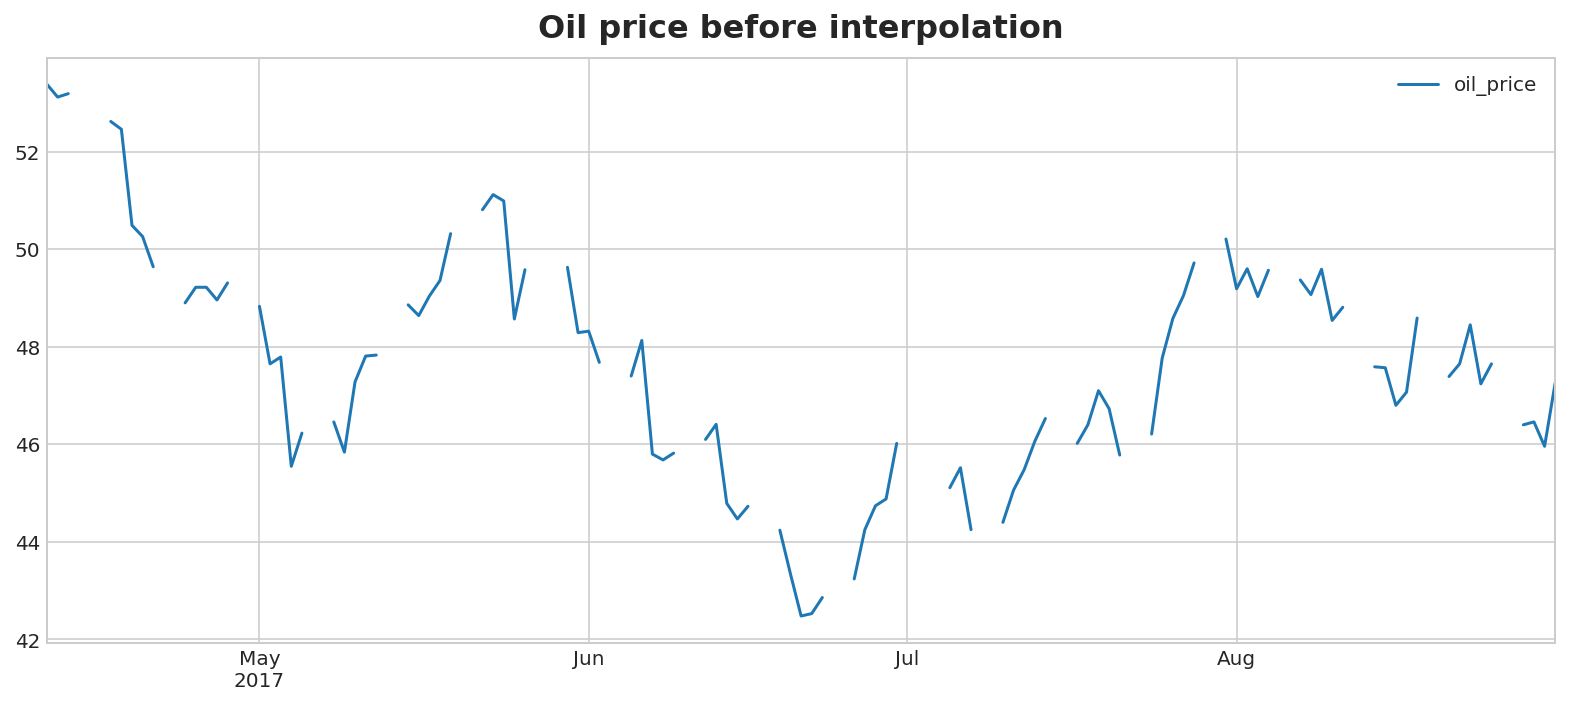

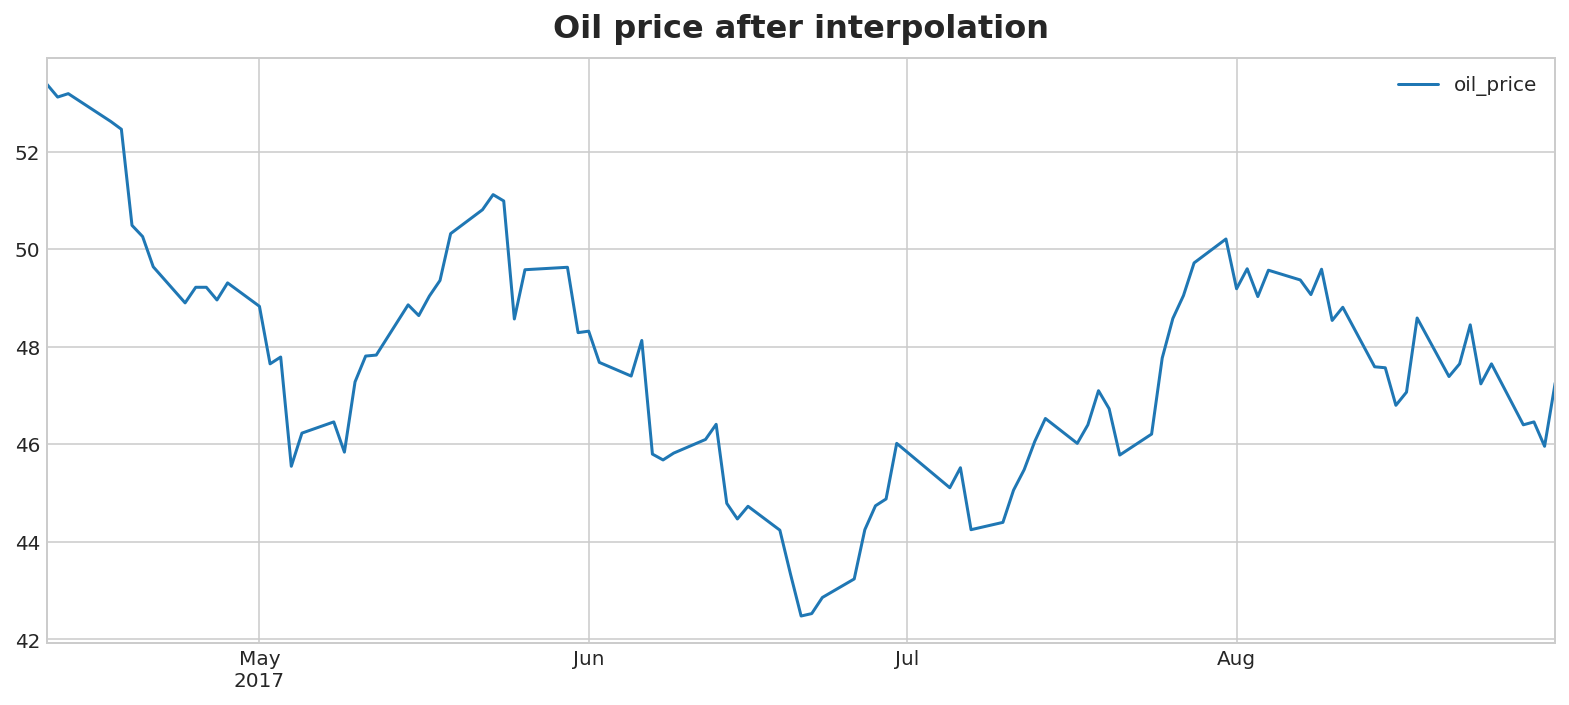

In [7]:
pd.options.mode.chained_assignment = None

df_oil_ = dates.join(df_oil).copy()
df_oil_.plot(title="Oil price before interpolation")
plt.show()

df_oil_["oil_price"] = df_oil_["oil_price"].interpolate()

df_oil_.plot(title="Oil price after interpolation")
plt.show()

I will add the oil price and a lag of 1 as a feature.

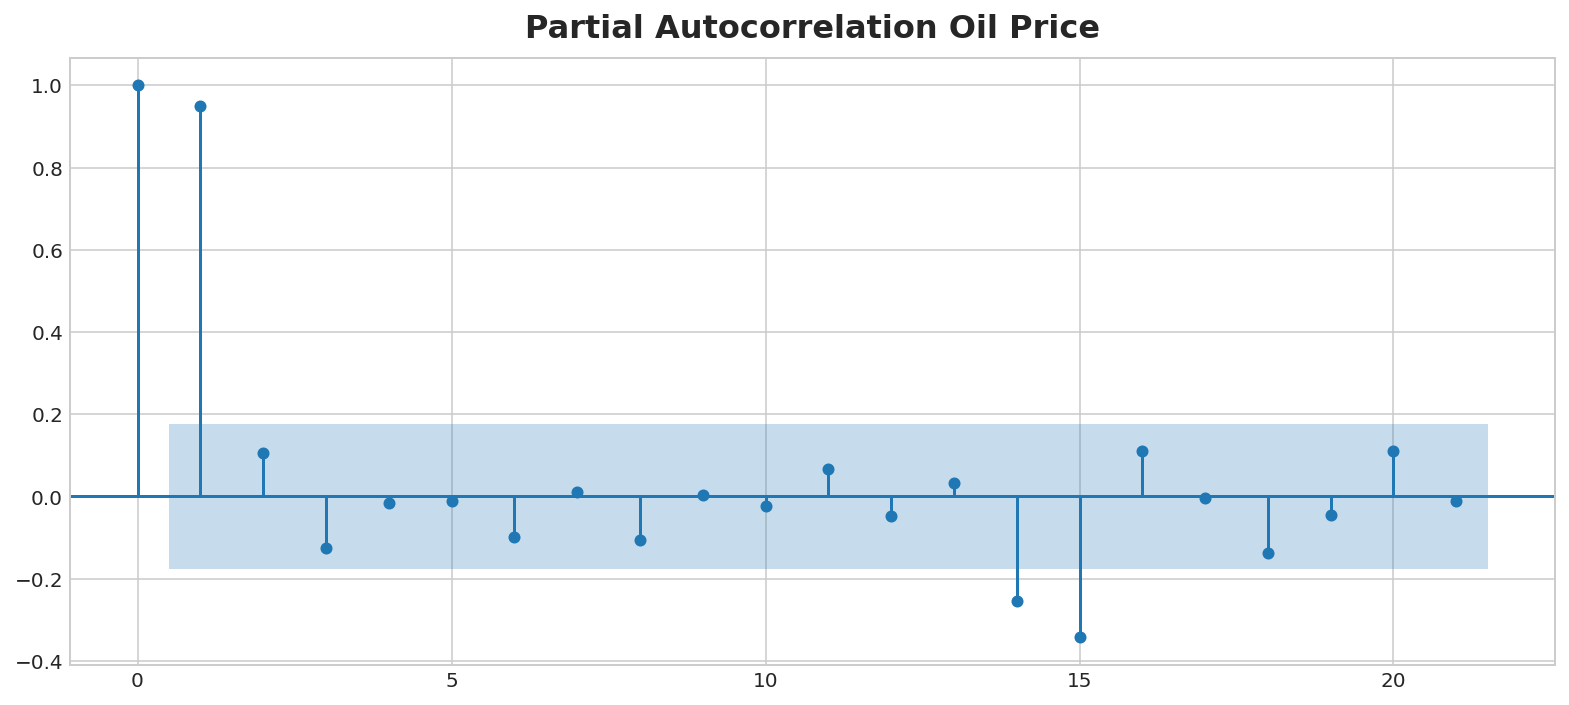

In [8]:
plot_pacf(df_oil_.loc[start_d:, :]["oil_price"], title="Partial Autocorrelation Oil Price")
plt.show()

In [9]:
df_oil_["oil_price_lag_1"] = df_oil_["oil_price"].shift(1)
df_oil_ = df_oil_.loc[start_d:, :]

pd.options.mode.chained_assignment = "warn"

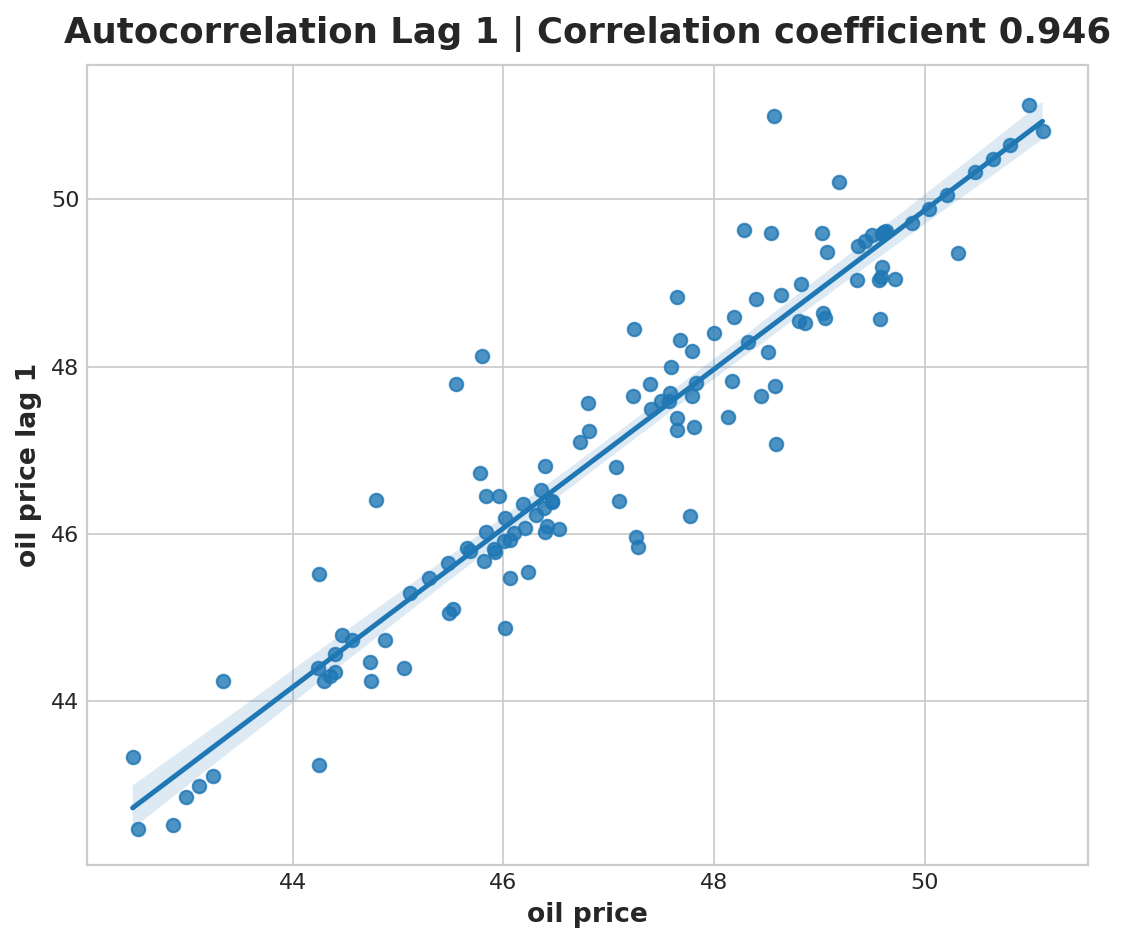

In [10]:
df_oil_ = pd.DataFrame(df_oil_, index=df_oil_.index, columns=df_oil_.columns)

corr_lag1 = np.corrcoef(df_oil_["oil_price"], df_oil_["oil_price_lag_1"])[0,1]

fig, ax = plt.subplots(1,1, figsize=(7,6), dpi=80)
sns.regplot(data=df_oil_, x="oil_price", y="oil_price_lag_1", ax=ax)
plt.xlabel("oil price")
plt.ylabel("oil price lag 1")
plt.title(f"Autocorrelation Lag 1 | Correlation coefficient {corr_lag1:.3}")
plt.show()

## Holiday/Special Days Features & Seasonal Features

The seasonal plot and the periodogram shows a **strong weekly** and a **smaller biweekly dependence**. Therefore i will add **weekly indicators** for the weekly dependence and monthly **fourier features** with order 2 for the biweekly dependence.

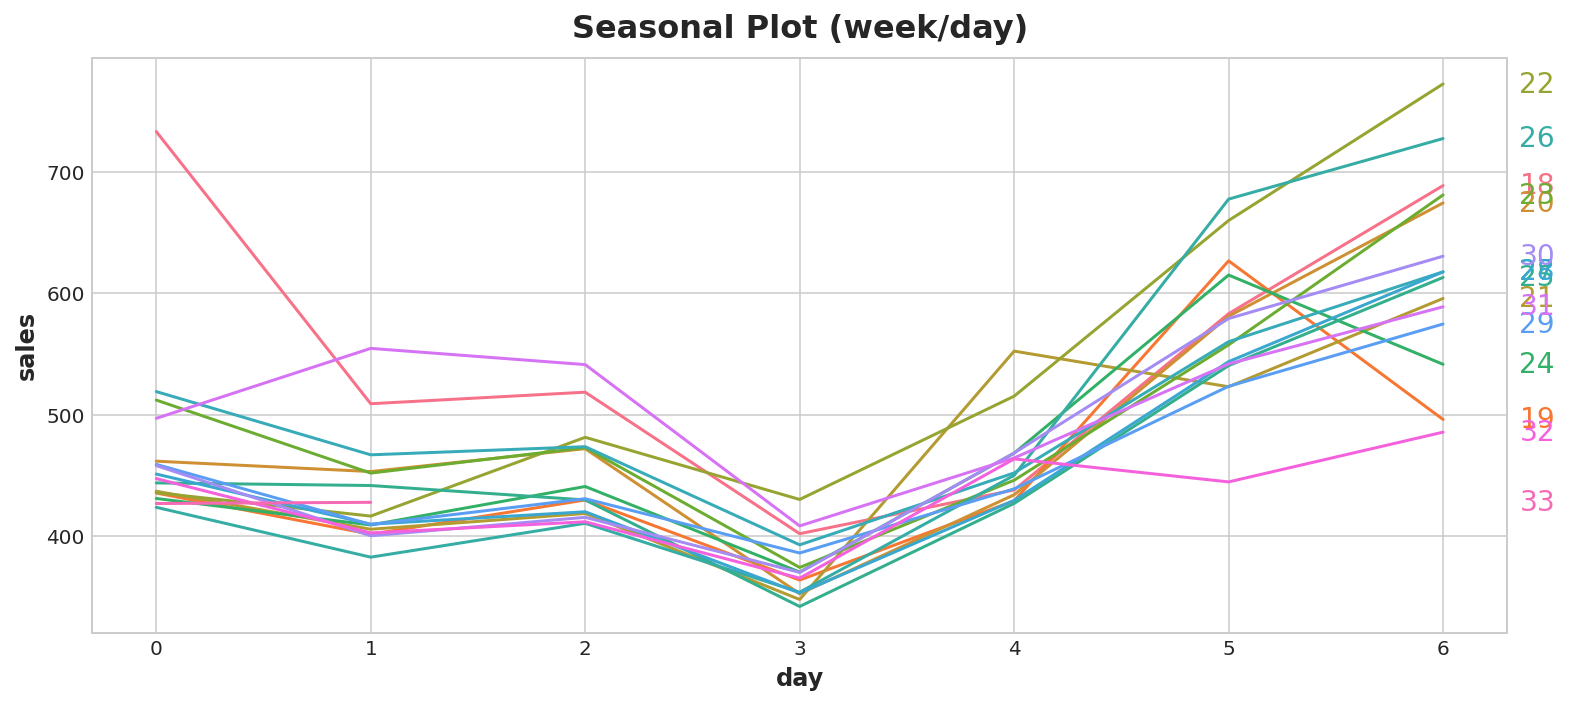

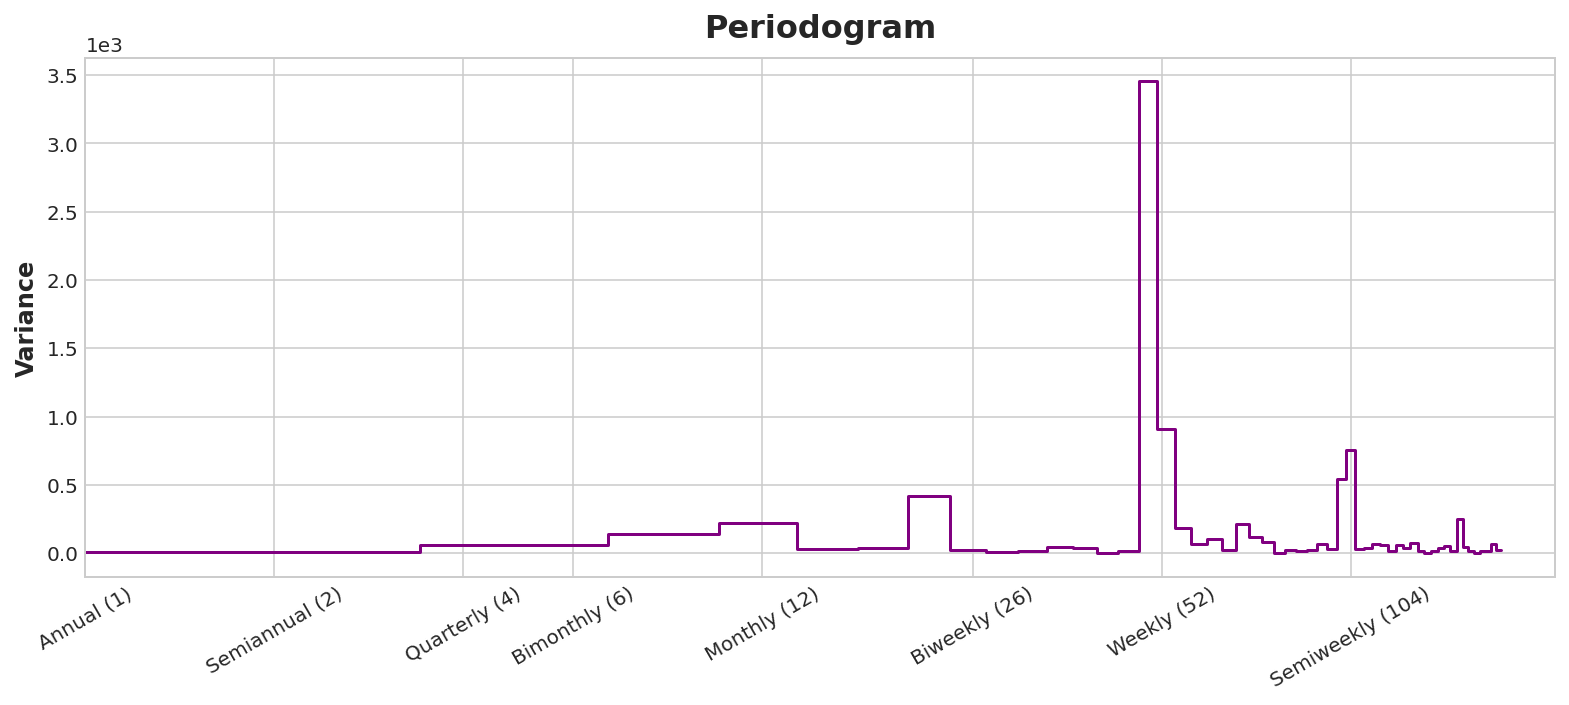

In [11]:
df_train_sales_ = df_train_sales.loc[start_d:, :].stack(["store_nbr", "family"]).reorder_levels(["store_nbr", "family", "date"], axis=0)
df_train_avg_sales = df_train_sales_.groupby("date").mean()
df_train_avg_sales_ = df_train_avg_sales.copy()
df_train_avg_sales_["week"] = df_train_avg_sales.index.week
df_train_avg_sales_["day"] = df_train_avg_sales.index.dayofweek
seasonal_plot(df_train_avg_sales_, y="sales", period="week", freq="day")
plt.show()

plot_periodogram(df_train_avg_sales.squeeze())
plt.show()

del df_train_sales_, df_train_avg_sales_

The feature 'work day' will distinguish between a work day or a free day, considering holidays and weekends. I will also add a feature to distinguish between normal free days and special holidays.

In [12]:
df_holiday_ = df_holiday.copy()

df_holiday_ = (
    df_holiday_
    .query("locale in ['National', 'Regional']")
    .loc[:, :]
)

df_holiday_ = dates.join(df_holiday_)

df_holiday_["day_of_week"] = df_holiday_.index.dayofweek
df_holiday_["month"] = df_holiday_.index.month

# Feature work day
df_holiday_["work_day"] = 1
df_holiday_.loc[df_holiday_["day_of_week"] > 4, "work_day"] = 0
df_holiday_.loc[df_holiday_["type"] == "Work Day", "work_day"] = 1
df_holiday_.loc[df_holiday_["type"] == "Bridge", "work_day"] = 0
df_holiday_.loc[df_holiday_["type"] == "Transfer", "work_day"] = 0
df_holiday_.loc[df_holiday_["type"] == "Additional", "work_day"] = 0

df_holiday_.loc[(df_holiday_["transferred"] == False) & (df_holiday_["type"] == "Holiday"), "work_day"] = 0
df_holiday_.loc[(df_holiday_["transferred"] == True) & (df_holiday_["type"] == "Holiday"), "work_day"] = 1
df_holiday_.loc[(df_holiday_["transferred"] == False) & (df_holiday_["type"] == "Transfer"), "work_day"] = 0


# Feature holiday
df_holiday_["holiday"] = 0
df_holiday_.loc[df_holiday_["type"] == "Bridge", "holiday"] = 1
df_holiday_.loc[df_holiday_["type"] == "Transfer", "holiday"] = 1
df_holiday_.loc[df_holiday_["type"] == "Additional", "holiday"] = 1

df_holiday_.loc[(df_holiday_["transferred"] == False) & (df_holiday_["type"] == "Holiday"), "holiday"] = 1
df_holiday_.loc[(df_holiday_["transferred"] == True) & (df_holiday_["type"] == "Holiday"), "holiday"] = 0
df_holiday_.loc[(df_holiday_["transferred"] == False) & (df_holiday_["type"] == "Transfer"), "holiday"] = 1


df_holiday_.drop(["locale", "locale_name", "description", "transferred", "day_of_week", "month", "type"], axis=1, inplace=True)

df_holiday_ = df_holiday_.astype(
    {
    "work_day": "category",
    "holiday":"category",
    }
)

df_holiday_ = df_holiday_[~df_holiday_.index.duplicated(keep='first')]

# Deterministic Process

In [13]:
y = df_train_sales
fourier = CalendarFourier(freq = 'M', order = 2)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = True,
                          constant = True,
                          drop = True,
                          additional_terms = [fourier],
                         )
X = dp.in_sample()
X_test = dp.out_of_sample(steps = 16)

In [14]:
X = X.join(df_holiday_)
X = X.join(df_oil_)

X_test = X_test.join(df_holiday_)
X_test = X_test.join(df_oil_)

In [15]:
X_all = pd.concat((X, X_test), axis=0)

numerical_cols = ['trend', 'oil_price', 'oil_price_lag_1']

sc = RobustScaler()
X_all[numerical_cols] = sc.fit_transform(X_all[numerical_cols])

X = X_all.loc[:end_d,:]
X_test = X_all.loc[test_start_d:,:]

In [16]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)",work_day,holiday,oil_price,oil_price_lag_1
2017-05-01,1.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0,1,0.566845,0.600343
2017-05-02,1.0,-0.983607,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,1,0,0.146168,0.545455
2017-05-03,1.0,-0.967213,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,1,0,0.196078,0.140652
2017-05-04,1.0,-0.950820,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,1,0,-0.602496,0.188679
2017-05-05,1.0,-0.934426,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,1,0,-0.360071,-0.579760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,0.672131,0.0,0.0,0.0,1.0,0.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,0,1,0.559715,0.445969
2017-08-12,1.0,0.688525,0.0,0.0,0.0,0.0,1.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0,0,0.414736,0.538593
2017-08-13,1.0,0.704918,0.0,0.0,0.0,0.0,0.0,1.0,0.651372,-0.758758,-0.988468,0.151428,0,0,0.269756,0.399085
2017-08-14,1.0,0.721311,0.0,0.0,0.0,0.0,0.0,0.0,0.485302,-0.874347,-0.848644,0.528964,1,0,0.124777,0.259577


# Model Base

I will use an **ensemble** of serveral learners to predict the sales. One special ensemble technique is called **stacking**, thereby a base learner (in this case linear regression) makes predictions for the training as well as the test set. These **predictions are then used as features** in the training of the 'level 2' learners.

We wont use a stand alone validation set, but rather **time series cross validation** for the second level learners. Time series cross validation takes into acount the time dependence of a timeseries.

In [17]:
model_lnr = LinearRegression(fit_intercept=False, n_jobs=-1) #Since the DP created a constant, an additional intercept is not necessary.
model_lnr.fit(X, y)

y_fit_lnr = pd.DataFrame(model_lnr.predict(X), index = X.index, columns = y.columns).clip(0.)
y_pred_lnr = pd.DataFrame(model_lnr.predict(X_test), index = X_test.index, columns = y.columns).clip(0.)

y_stack = y.stack(['store_nbr', 'family'])
y_stack['lnr'] = y_fit_lnr.stack(['store_nbr', 'family'])['sales']

y_deseasoned = y - y_fit_lnr

X_base_pred = y_fit_lnr.append(y_pred_lnr) # stacking training and predictions of base learner

To give an overview, the following graph displays the root mean squared log error (RMSLE) on the training set. The several stores are grouped by the product family. An obvious discrepancy is the family 'SCHOOL AND OFFICE SUPPLIES' which has a comparatively poor performance.

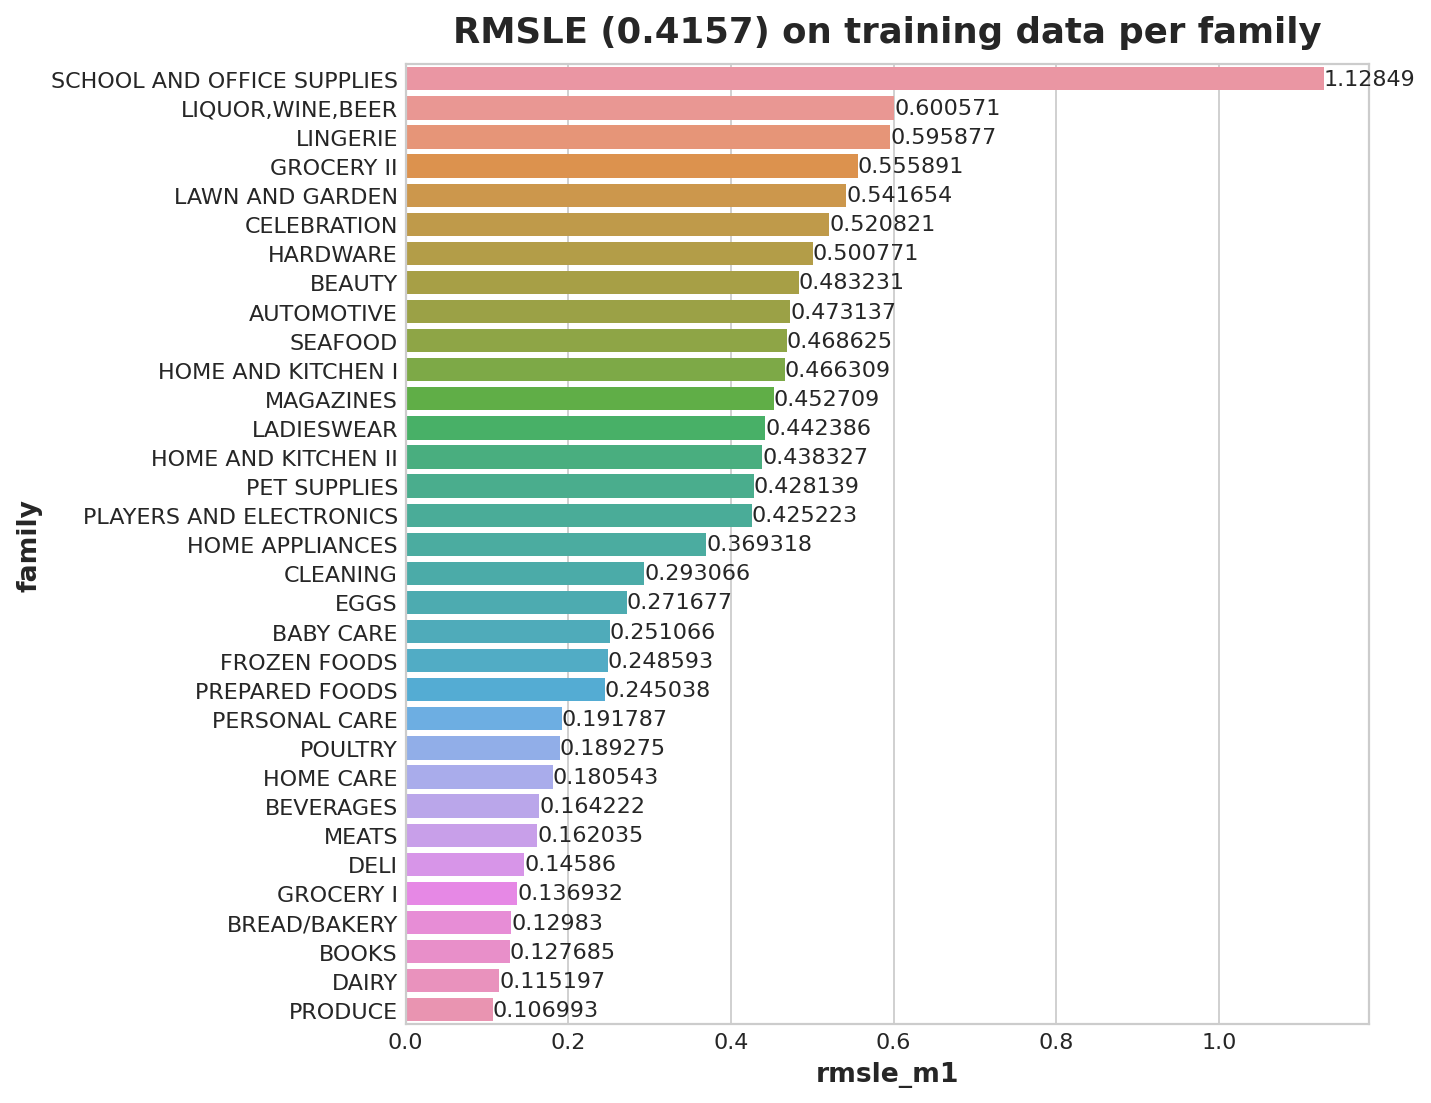

In [18]:
rmslr_family_v1 = y_stack.groupby('family').apply(lambda s : np.sqrt(msle(s['sales'], s['lnr'])))
rmslr_family_v1 = rmslr_family_v1.to_frame("rmsle_m1")
rmslr_family_v1 = rmslr_family_v1.sort_values(by="rmsle_m1", ascending=False)

rmslr_family_v1.reset_index()
fig, ax = plt.subplots(figsize=(9,7), dpi=80)
sns.barplot(data=rmslr_family_v1.reset_index(), x="rmsle_m1", y="family", order=rmslr_family_v1.sort_values("rmsle_m1", ascending=False).index, ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title(f"RMSLE ({np.sqrt(msle(y, y_fit_lnr)):.4}) on training data per family")
plt.show()

In [19]:
# families = y.columns.unique(level=2).values
# for i in families:
#     print(i)

Lets look at the training data, the fitted curve and the model forecast. We can see that some forecast are reasonable, like e.g. the forecast for 'SEAFOOD'. On the other hand the forecast for 'SCHOOL AND OFFICE SUPPLIES' seems to be harder.

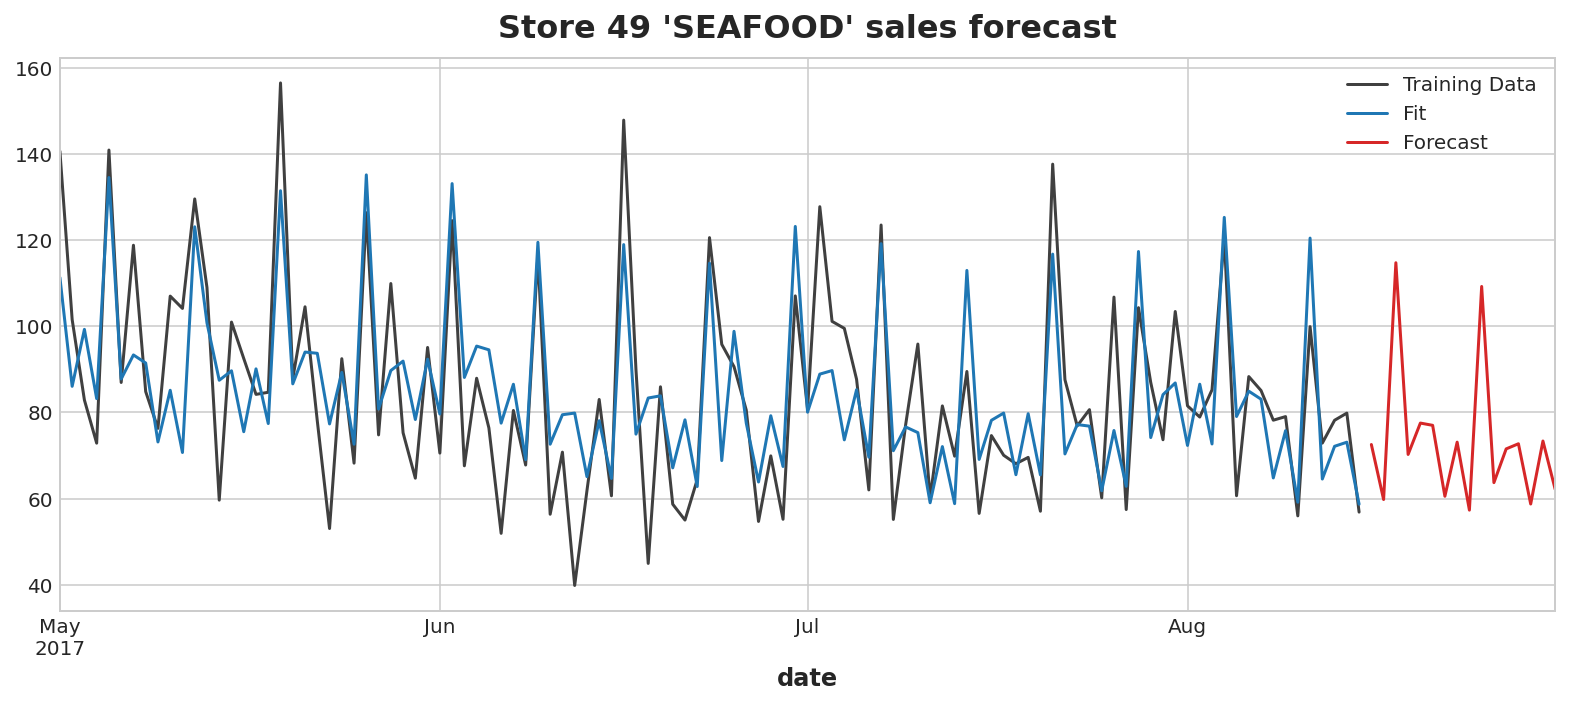

In [20]:
fam = "SEAFOOD"
store_nbr = '49'

fig, ax = plt.subplots()
idx = pd.IndexSlice

ax = y.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, color='0.25', title=f"Store {store_nbr} '{fam}' sales forecast", label="Training Data")
ax = y_fit_lnr.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, label="Fit")
ax = y_pred_lnr.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, label="Forecast", color='C3')

_ = ax.legend()
plt.show()

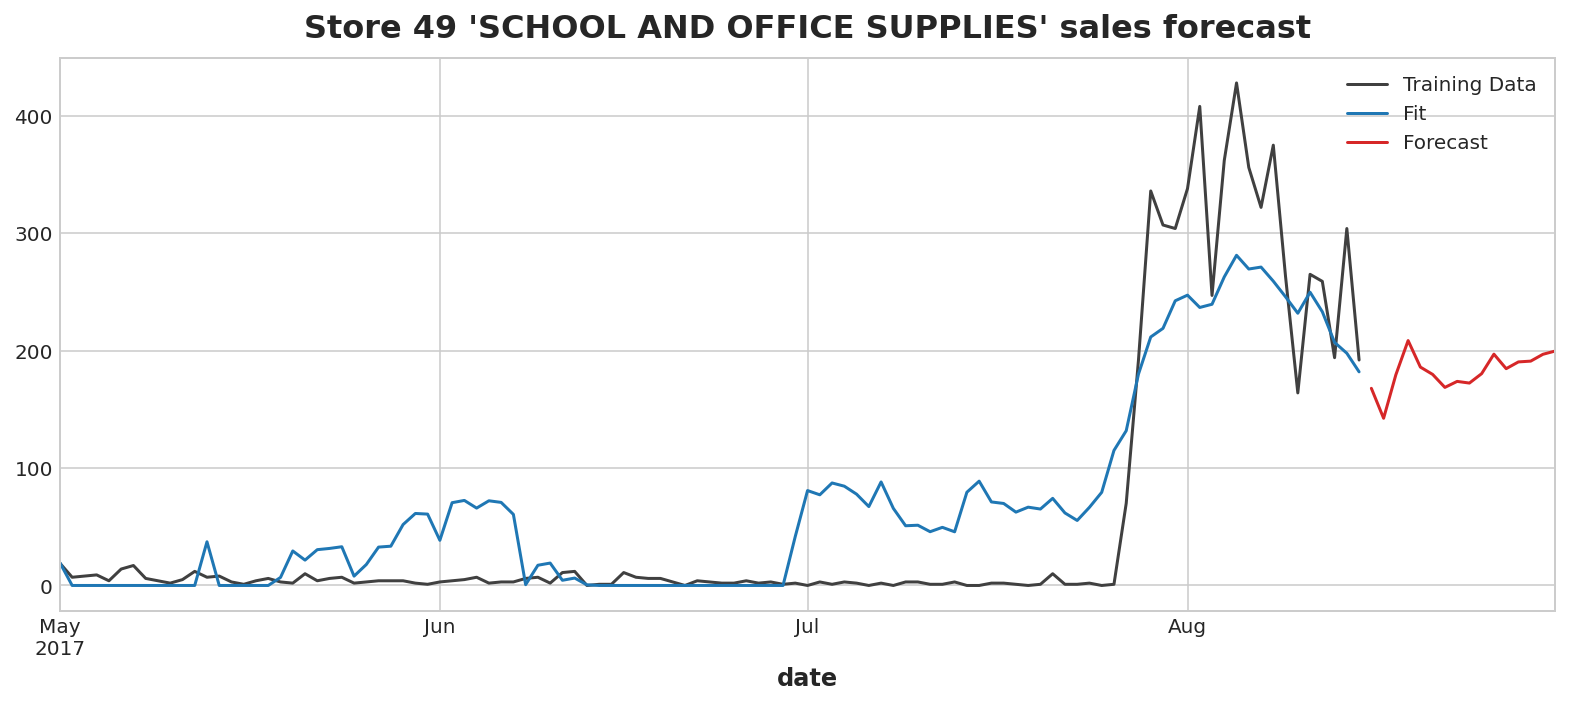

In [21]:
fam = "SCHOOL AND OFFICE SUPPLIES"
store_nbr = '49'

fig, ax = plt.subplots()
idx = pd.IndexSlice

ax = y.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, color='0.25', title=f"Store {store_nbr} '{fam}' sales forecast", label="Training Data")
ax = y_fit_lnr.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, label="Fit")
ax = y_pred_lnr.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, label="Forecast", color='C3')

_ = ax.legend()
plt.show()

# Serial Dependence Features

Based on the results of the partial autocorrelation plots, i will add lags for the different families. I will also add lags for the promotion feature. The numerical features will be standardized using the robust scaler.

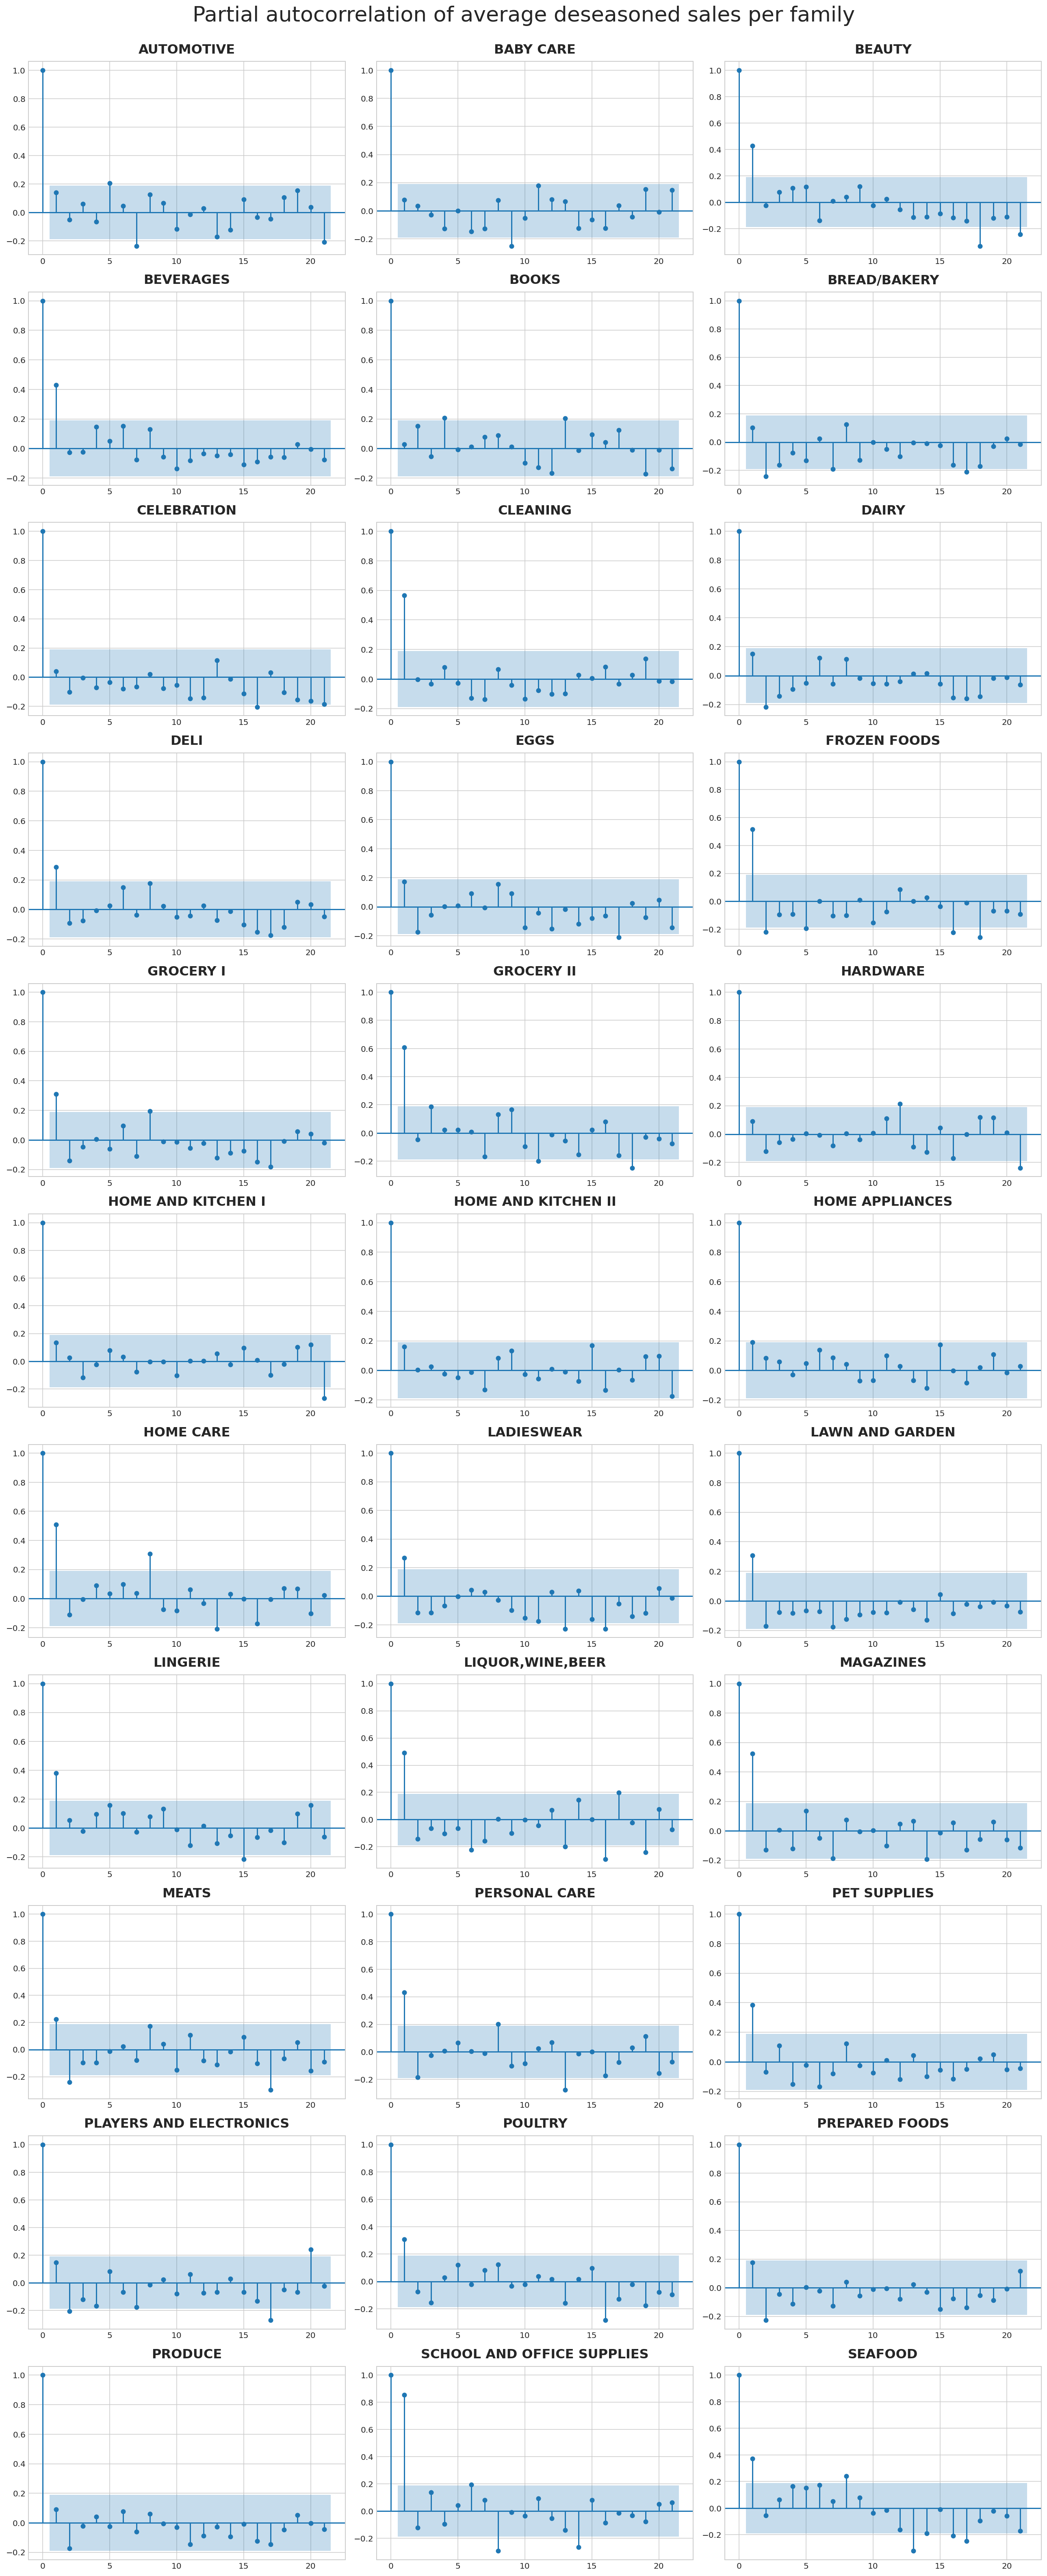

In [22]:
family_names = y_deseasoned.columns.get_level_values(level=2).categories
avg_sales_family = y_deseasoned.groupby("family", axis=1).mean()

fig, ax = plt.subplots(11, 3, figsize=(6*3,4*11))

for i in range(0, 33, 3):
    for j in range(3):
        data =avg_sales_family.loc[:, family_names[i+j]]
        fig = plot_pacf(data, ax=ax[i//3,j], title=f"{family_names[i+j]}")
fig.suptitle('Partial autocorrelation of average deseasoned sales per family', fontsize=26, y=1)
plt.show()

In [23]:
family_lags = {
    'AUTOMOTIVE' : 5,
    'BEAUTY' : 1,
    'BEVERAGES' : 3,
    'BOOKS' : 0,
    'BREAD/BAKERY' : 3,
    'CELEBRATION' : 2,
    'CLEANING' : 1,
    'DAIRY' : 4,
    'DELI' : 3,
    'EGGS' : 2,
    'FROZEN FOODS' : 1,
    'GROCERY I' : 3,
    'GROCERY II' : 1,
    'HOME AND KITCHEN I' : 0,
    'HOME AND KITCHEN II' : 0,
    'HOME APPLIANCES' : 1,
    'HOME CARE' : 8,
    'LAWN AND GARDEN' : 2,
    'LINGERIE' : 1,
    'LIQUOR,WINE,BEER' : 6,
    'MAGAZINES' : 1,
    'MEATS' : 2,
    'PERSONAL CARE' : 3,
    'PET SUPPLIES' : 1,
    'PLAYERS AND ELECTRONICS' : 4,
    'POULTRY' : 4,
    'PREPARED FOODS' : 4,
    'PRODUCE' : 2,
    'SCHOOL AND OFFICE SUPPLIES' : 8,
    'SEAFOOD' : 8,
}

In [24]:
promo_lag = 4
standardize_numerical = True

X_features = []
X_test_l = []

def make_lags(df, n_lags, name="lag"):
    tmp_df = df.copy()
    for i in range(1, n_lags+1):
        tmp_df = tmp_df.join(df.shift(i), rsuffix=f"_{name}_{i}")

    tmp_df = tmp_df.fillna(method="backfill", axis=0)
    return tmp_df


for i in range(y.shape[1]):
        
    scaler = RobustScaler()
    single_sales_df = X_base_pred.iloc[:, [i]].droplevel(level=[0,1], axis=1)
    single_promo_df = df_train_promo.iloc[:, [i]].droplevel(level=[0,1], axis=1)
    promo_col_name = single_promo_df.columns[0]
    single_promo_df = single_promo_df.rename(columns={promo_col_name : f"{promo_col_name}_promo"})

    family_ = y.iloc[:, i].name[2]

    if family_ in family_lags.keys():
        single_sales_df = make_lags(single_sales_df, family_lags[family_])
        
        single_promo_df = make_lags(single_promo_df, promo_lag)
        single_df = pd.concat((single_sales_df, single_promo_df), axis=1)

        if standardize_numerical:
            single_df = pd.DataFrame(scaler.fit_transform(single_df), index=single_df.index, columns=single_df.columns)

        train_feat = X.join(single_df, how="inner")
        X_features.append((family_, train_feat))

        test_feat = X_test.join(single_df, how="inner")
        X_test_l.append((family_, test_feat))
    else:
        single_promo_df = make_lags(single_promo_df, promo_lag)
        single_df = pd.concat((single_sales_df, single_promo_df), axis=1)
        
        if standardize_numerical:
            single_df = pd.DataFrame(scaler.fit_transform(single_df), index=single_df.index, columns=single_df.columns)

        train_feat = X.join(single_df, how="inner")
        X_features.append((family_, train_feat))

        test_feat = X_test.join(single_df, how="inner")
        X_test_l.append((family_, test_feat))

# Model 2 Level

All families except 'SCHOOL AND OFFICE SUPPLIES' will use a **voting regessor consisting out of ridge and support vector regression**. For the family 'SCHOOL AND OFFICE SUPPLIES' i will use an **extra trees regressor** (similar to a random forest but with additional stochastic behaviour).

The hyperparameters are selected via the **optuna** library (20 trails) and **time series cross validation** (6 folds).

In [25]:

optuna.logging.set_verbosity(optuna.logging.WARNING)


kf = TimeSeriesSplit(n_splits=6)

def objective_Ridge(trial):    
    ridge_params = dict(
        alpha = trial.suggest_float("alpha",1e-3, 1e3),
        fit_intercept = False,
    )
    model = Ridge(**ridge_params)
    scores = cross_val_score(model, X_train, y_train, cv=kf, n_jobs=-1) #R2 cv scores
    
    return np.array(scores).mean()


def objective_SVR(trial):
    #svm uses the rbf kernel
    svr_params = dict(
        C = trial.suggest_loguniform("C", 1e-1, 2e-0),
        epsilon = trial.suggest_float("epsilon", 1e-2, 1e-0),
        kernel = 'rbf',
    )
    model = SVR(**svr_params)
    scores = cross_val_score(model, X_train, y_train, cv=kf, n_jobs=-1)
    
    return np.array(scores).mean()

In [26]:
d_objective_1 = {
    "Ridge" : objective_Ridge,
    "SVR" : objective_SVR,
}

def bayesian_search(d_objective, n_trials=20):
    d_studies = dict()
    for method, objective in d_objective.items():
        
        study = optuna.create_study(direction="maximize", study_name=method)
        study.optimize(objective, n_trials=n_trials)
        d_studies[method] = study
        
    return d_studies

In [27]:
warnings.filterwarnings("ignore")

rs = 1
estimators = {}
y_fit_stk = []
y_pred_stk = []


for i, store_fam_idx in tqdm(enumerate(y), total=y.shape[1]):
    
    X_family, X_train = X_features[i]
    y_train = y.loc[:, store_fam_idx]
    _, X_test = X_test_l[i]
    
    if X_family != "SCHOOL AND OFFICE SUPPLIES":
        d_studies_1 = bayesian_search(d_objective_1)
        
        ridge = Ridge(**d_studies_1["Ridge"].best_params, random_state=rs)
        svr = SVR(**d_studies_1["SVR"].best_params)
        
        model_m1 = VotingRegressor([('ridge', ridge), ('svr', svr)])
        model_m1.fit(X_train, y_train)
        
        estimators[y_train.name] = model_m1
        y_fit_stk.append(model_m1.predict(X_train))
        y_pred_stk.append(model_m1.predict(X_test))
                
    else:
        
        model_m2 = ExtraTreesRegressor(n_jobs=-1, random_state=rs)
        
        params_m2 = {
            'n_estimators': optuna.distributions.IntUniformDistribution(low=100, high=200, step=50),
            'max_depth' : optuna.distributions.IntUniformDistribution(low=1, high=10, step=1),
            'min_samples_split' : optuna.distributions.IntUniformDistribution(low=2, high=4, step=1),
            'min_samples_leaf' : optuna.distributions.IntUniformDistribution(low=1, high=4, step=1),
        }
        

        model_m2 = optuna.integration.OptunaSearchCV(estimator=model_m2, param_distributions=params_m2, cv=kf)
        model_m2.fit(X_train, y_train)
        
        estimators[y_train.name] = model_m2
        y_fit_stk.append(model_m2.predict(X_train))
        y_pred_stk.append(model_m2.predict(X_test))

warnings.filterwarnings("default")

  0%|          | 0/1782 [00:00<?, ?it/s]

In [28]:
y_fit_stk = pd.DataFrame(np.stack(y_fit_stk, axis=1), index=X.index, columns=y.columns)
y_fit_stk = y_fit_stk.stack(["store_nbr", "family"]).clip(0.0)

In [29]:
y_stack = y.stack(['store_nbr', 'family'])
rmsle_fit = np.sqrt(msle(y_stack, y_fit_stk))

y_stack["fit"] = y_fit_stk
rmslr_family_v2 = y_stack.groupby("family").apply(lambda s : np.sqrt(msle(s["sales"], s["fit"])))
rmslr_family_v2 = rmslr_family_v2.to_frame("rmsle_m2").sort_values(by="rmsle_m2", ascending=False)

del y_stack

The overall RMSLE is smaller compared to the performance on the base learner. These error statistics are only meant as a quick overview to see if some of the more problematic families benefit from the stacking. Since these error metrics are based on the fitted data, they dont represent the performance of the model on unseen data and shouldnt be interpreted this way.

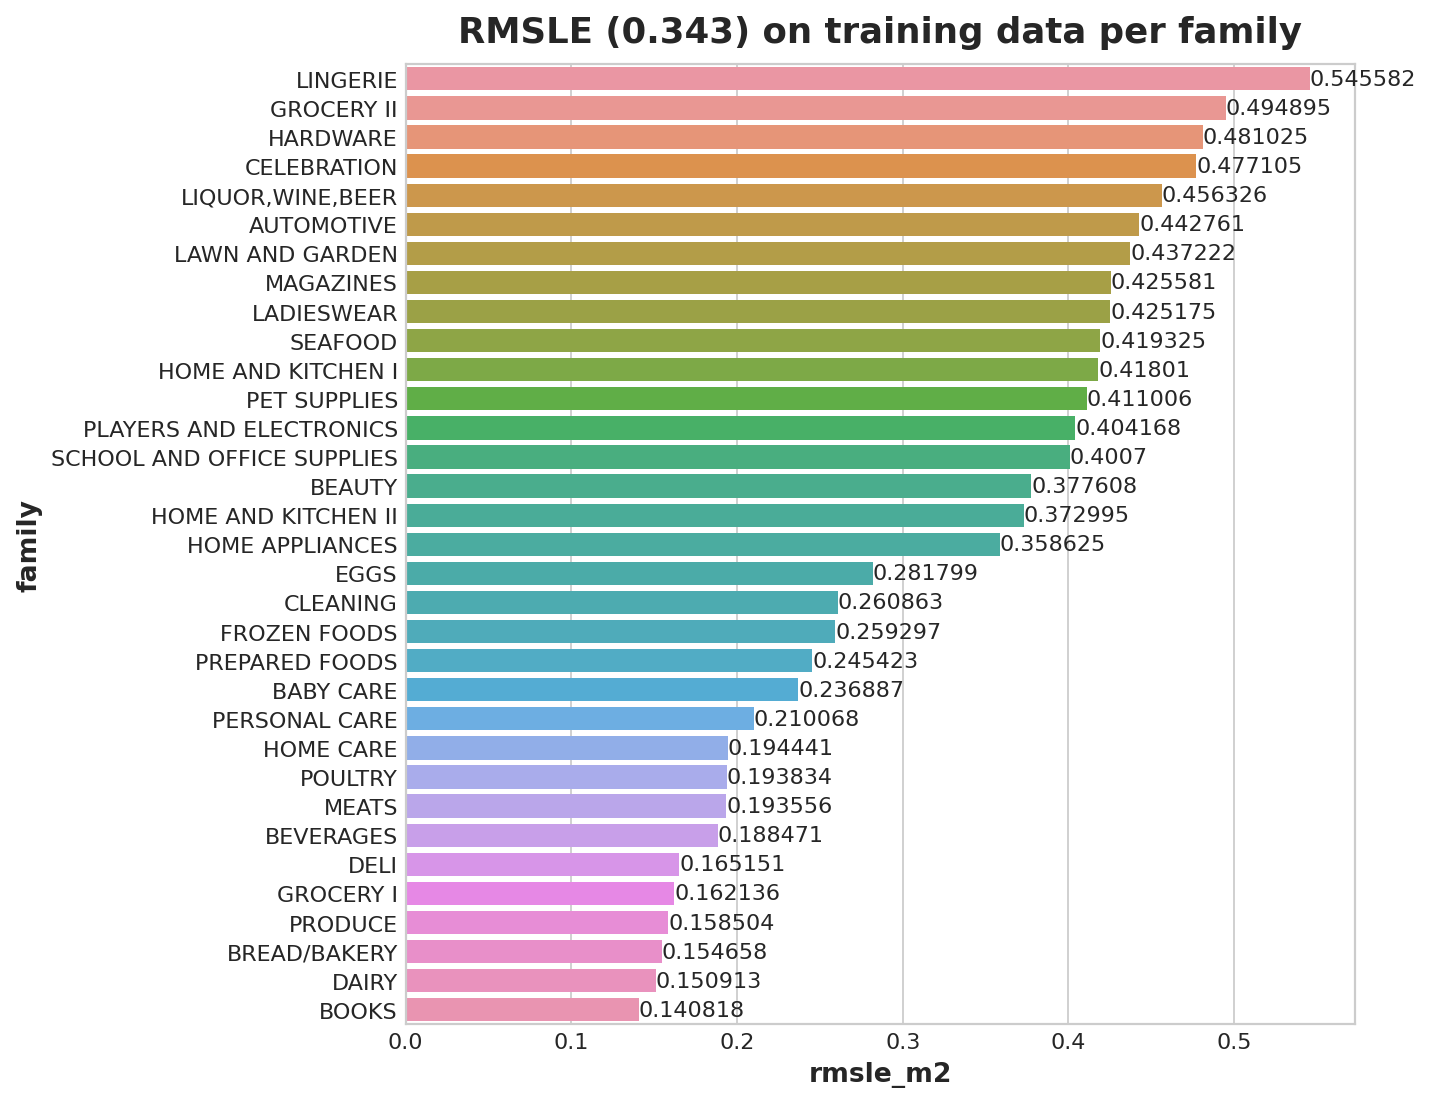

In [30]:
fig, ax = plt.subplots(figsize=(9,7), dpi=80)
sns.barplot(data=rmslr_family_v2.reset_index(), x="rmsle_m2", y="family", order=rmslr_family_v2.sort_values("rmsle_m2", ascending=False).index, ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title(f"RMSLE ({rmsle_fit:.4}) on training data per family")
plt.show()

In [31]:
models_rmslr = rmslr_family_v1.join(rmslr_family_v2)
models_rmslr_ = models_rmslr.copy()
models_rmslr_.columns = pd.MultiIndex.from_product([['errors'], models_rmslr_.columns])
models_rmslr_ = models_rmslr_.stack()
models_rmslr_.index = models_rmslr_.index.set_names(["family", "models"])
models_rmslr_ = models_rmslr_.reset_index()

We can see different performances of the base and stacking model on different categories.
While the unregularized base model has a smaller rmsle on the easier categories (overfitting).
The regularized but more powerful stacking model has a smaller rmsle on the harder categories.

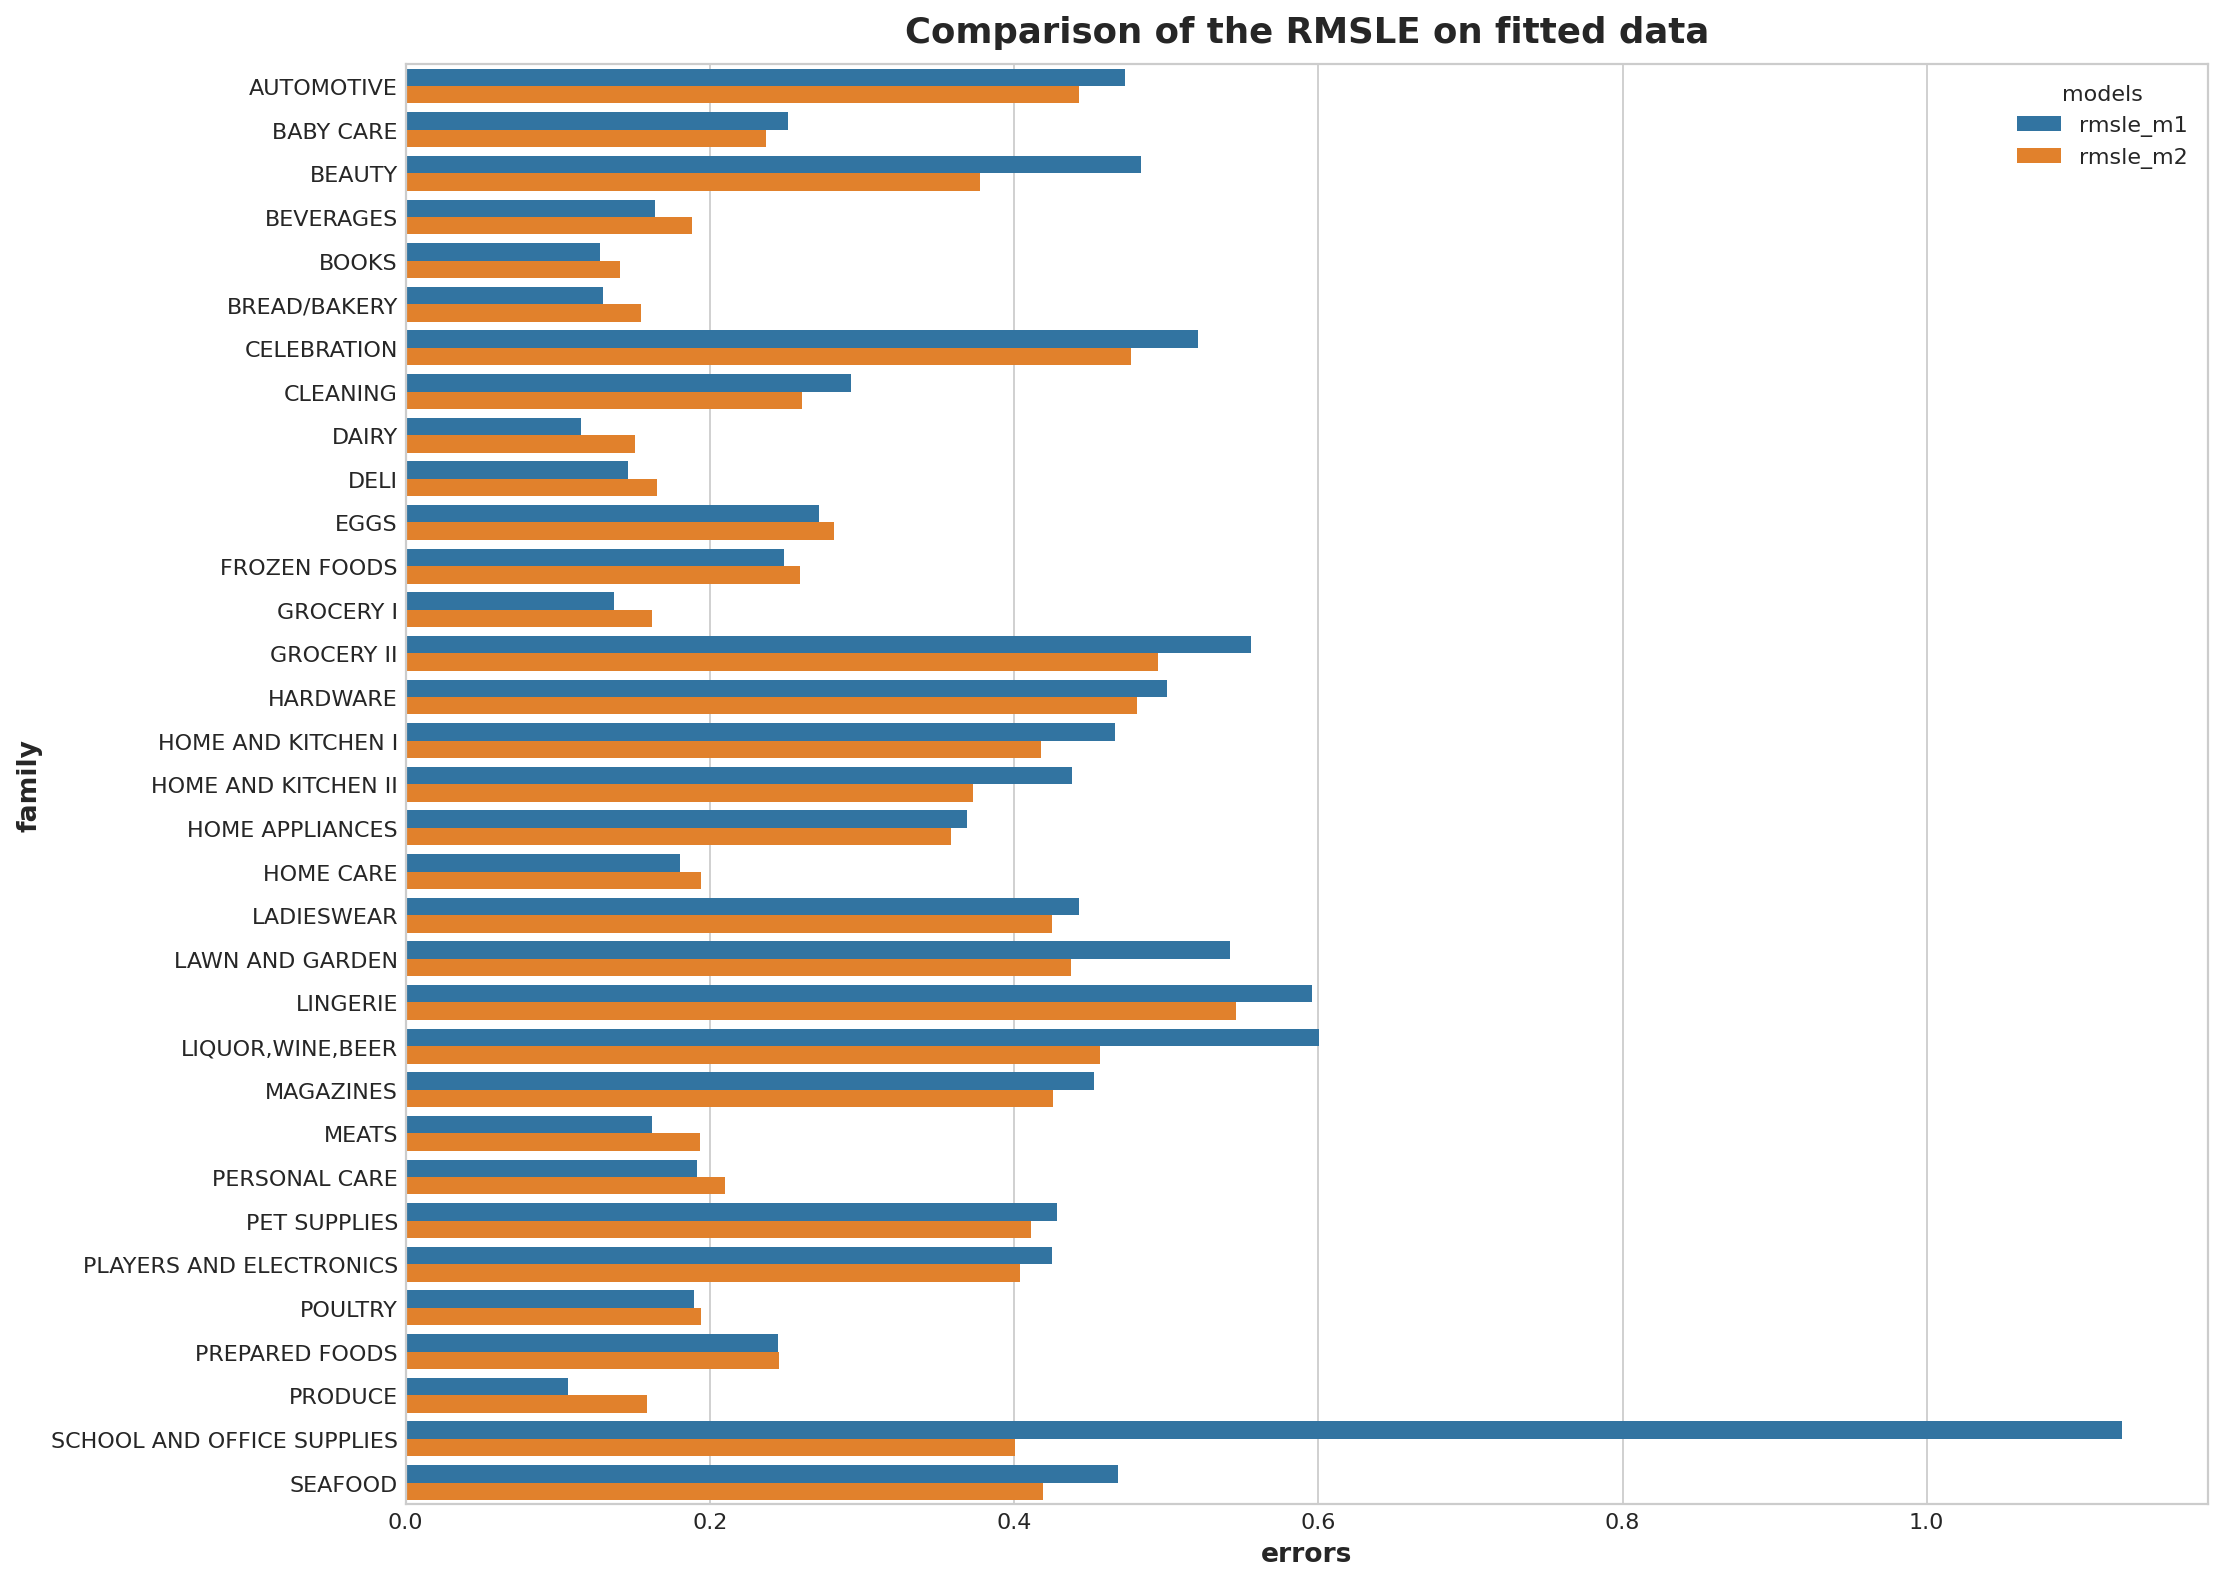

In [32]:
fig, ax = plt.subplots(figsize=(14,10), dpi=80)
sns.barplot(data=models_rmslr_, x="errors", y="family", hue="models", ax=ax)
ax.set_title("Comparison of the RMSLE on fitted data")
plt.show()

In [33]:
y_pred_stk = pd.DataFrame(np.stack(y_pred_stk, axis=1), index = X_test.index, columns = y.columns).clip(0.)
y_pred_stk = y_pred_stk.stack(['store_nbr', 'family'])

In [34]:
y_fit_stk.index = y_fit_stk.index.rename(["date", "store_nbr", "family"])
y_fit_stk = y_fit_stk.reorder_levels(["store_nbr", "family", "date"]).sort_index()

y_pred_stk.index = y_pred_stk.index.rename(["date", "store_nbr", "family"])
y_pred_stk = y_pred_stk.reorder_levels(["store_nbr", "family", "date"]).sort_index()

y_fit_stk_ = y_fit_stk.unstack(["store_nbr", "family"])
y_pred_stk_ = y_pred_stk.unstack(["store_nbr", "family"])

In [35]:
# families = y.columns.unique(level=2).values
# for i in families:
#     print(i)

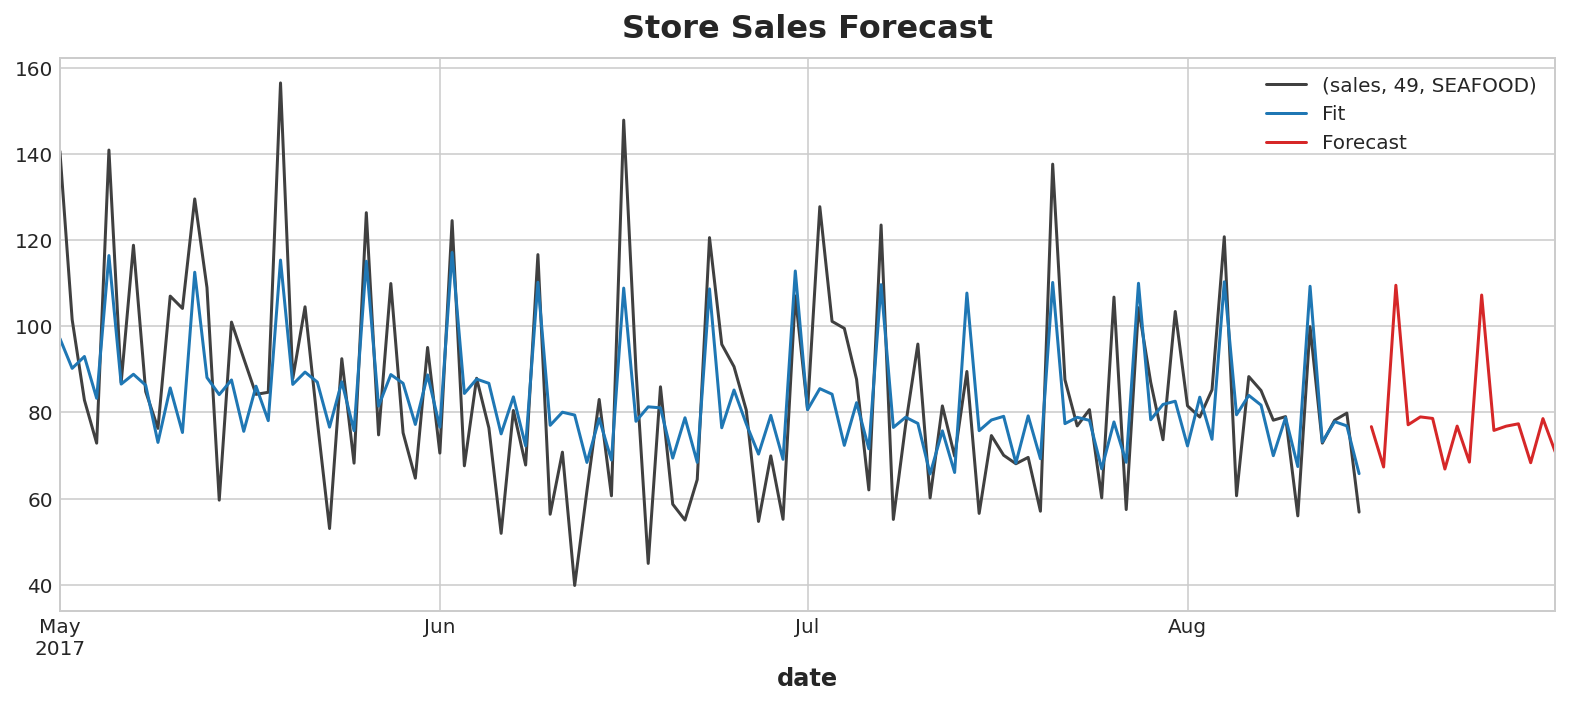

In [36]:
fam = "SEAFOOD"
store_nbr = '49'

fig, ax = plt.subplots()

ax = y.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, color='0.25', title="Store Sales Forecast")
ax = y_fit_stk_.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, label="Fit")
ax = y_pred_stk_.loc[idx[:], idx['sales', store_nbr, fam]].plot(ax=ax, label="Forecast", color='C3')

_ = ax.legend()
plt.show()

In [37]:
final_pred = df_test.drop("onpromotion", axis=1)
final_pred = final_pred.join(y_pred_stk)
final_pred.to_csv("submission.csv", index=False)
final_pred

id      sales
store_nbr family     date                          
1         AUTOMOTIVE 2017-08-16  3000888   3.779792
                     2017-08-17  3002670   4.020588
                     2017-08-18  3004452   7.041354
                     2017-08-19  3006234   5.711466
                     2017-08-20  3008016   2.615197
...                                  ...        ...
9         SEAFOOD    2017-08-27  3022271  21.428337
                     2017-08-28  3024053  13.478496
                     2017-08-29  3025835  13.760589
                     2017-08-30  3027617  14.126120
                     2017-08-31  3029399  14.681666

[28512 rows x 2 columns]